# IMPORT and standard tweaking

In [1]:
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.oauth2 as oauth2
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
%matplotlib inline

#visualization option

In [2]:
my_client_id=os.getenv('spoti_CLIENT_ID')
my_client_secret=os.getenv('spoti_CLIENT_SECRET')
sp=spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret))


In [3]:
# display all columns
pd.set_option('display.max_columns', None)

#### import csv created with 'top50_fetching-data.ipynb'

In [4]:
top50=pd.read_csv(r'data/analysis/top50_charts_songs_2017-2020.csv')

In [5]:
len(top50)

36206

In [6]:
top50.columns

Index(['Position', 'Track Name', 'Artist', 'Streams', 'URL', 'filename', 'ID',
       'date', 'country', 'group', 'duration_ms', 'popularity', 'acousticness',
       'danceability', 'energy', 'key', 'instrumentalness', 'liveness',
       'loudness', 'mode', 'speechiness', 'valence', 'tempo', 'loud_start'],
      dtype='object')

remarks on the features
* 'valence' indicates the 'happiness' the lower the score the sader the music. [refercence](https://community.spotify.com/t5/Content-Questions/Valence-as-a-measure-of-happiness/td-p/4385221)
* mode 0/1 indicates major/minor (dur/moll) 1=Major / 0=Minor

In [7]:
#rename column length to duration to match the kaggle dataframe
top50=top50.rename(columns={'length':'duration_ms'})


#### dtypes tweaking

In [8]:
top50.dtypes

Position              int64
Track Name           object
Artist               object
Streams               int64
URL                  object
filename             object
ID                   object
date                 object
country              object
group                object
duration_ms           int64
popularity            int64
acousticness        float64
danceability        float64
energy              float64
key                   int64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
valence             float64
tempo               float64
loud_start          float64
dtype: object

In [9]:
#date to datetime
top50.date=pd.to_datetime(top50.date, format="%Y-%m-%d", yearfirst=True)

# mode and key are categroical values

#make mode categorical and name 'Major', 'Minor'
top50['mode'] = np.where(top50['mode'].apply(str)=='1','Major','Minor')

#make key categorical and label it more readable
top50['key'] = 'key_'+top50['key'].apply(str)

#introduce numeric column if Top50 song or not 0/1
top50['top50']=1

In [10]:
#### make sure our base does not include any top50 charts songs

# CAN WE MODEL THE MUSICAL FEATURES OF A HIT
* Supervised learning model w/ random forest, decision tree,  and k nearest neighbours, support vector ml
* Will the musical features of snongs labeled as top50  be distinguishable enough?
* Using a large kaggle song data base as baseline to compare against songs from top50 charts
* https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

#### only want to keep unique songs: 'top50_unique'
* drop date, country, Position, filename, popularity so we can grup for every song ID
* they arent important for the analysis at hand

In [11]:
len(top50.ID.unique())

9079

In [12]:

#dropping duplicates
top50_unique=top50.drop(['Position','filename','date','country','Streams','popularity'],axis=1).drop_duplicates(ignore_index=True)


In [13]:
print(len(top50))
print(len(top50_unique))

36206
9079


#### Set Up Spotify dataset from Kaggle as baseline to compare against

In [14]:
kaggle=pd.read_csv(r'data/kaggle/data.csv')

In [15]:
#adding column indicating they are not the top50 songs
kaggle['group']='base'

kaggle['top50']=0

In [16]:
# mode and key are categroical values

#make mode categorical and name 'Major', 'Minor'
kaggle['mode'] = np.where(kaggle['mode'].apply(str)=='1','Major','Minor')

#make key categorical and label it more readable
kaggle['key'] = 'key_'+kaggle['key'].apply(str)


#### subsetting for years 2018-2020

In [17]:
# only want to keep songs from 2018 to 2020 to avoid accidentally measuring change in music production
kaggle_year=kaggle[kaggle['year'].isin([2018,2019,2020])].reset_index(drop=True)
print('# of records: ',len(kaggle_year))

#sadly reissues of old songs cannot be filterd out as their release year is given as a current date 
# ex. Frank Sinatra and Joni Mitchel

# of records:  9337


#### kick songs included in top50 from kaggle df 
this will be my base to compare against

In [18]:
#option 1 kicking all Ids out
#base=kaggle_year[-kaggle_year['id'].isin(top50.ID)]

#option 2 kicking qunique IDs out
base=kaggle_year[-kaggle_year['id'].isin(top50_unique.ID)] 
#commented out unique to give major hits more wait through repetion

In [19]:
len(base)

8679

# SET UP FOR MODELLING
* create joint dataframe for analysis
* check multicollinearity
* check outliers
* create dummies for categorical variable (ex key & mode)
* standardize continuous variables

### create joint dataframe 
create joint df of top50_unique charts songs and songs from kaggle (base) DB I want to compare against

In [20]:
# list of relevant columns
continuous_feat=[
            "acousticness",
            "danceability",
            "duration_ms",
            "energy",
            "instrumentalness",
            "liveness",
            "loudness",
            "speechiness",
            "tempo",
            "valence"]

categorical_feat=["key","mode"]

target_feat=['top50']

#### DATA FRAME ORIGINAL VALUES

#### joint dataframe with true values 
named: analysis_true

In [21]:
#concat top50 DF with DF from kaggle that i use as base

analysis_true=pd.concat([top50_unique[target_feat+categorical_feat+continuous_feat],
                        base[target_feat+categorical_feat+continuous_feat]
                        ],
                       axis=0,
                        ignore_index=True)


#### DATA FRAME: SCALED AND STANDARDIZED
#### joint dataframe with standardized continuous variables
named: analysis_stan

In [22]:
from sklearn.preprocessing import StandardScaler


In [23]:
# fit without transform for later use when applying to new data 
# copy=False parameter overrites the values in the data frame instead of jus returning the standardized data
scaler = StandardScaler(copy=False).fit(analysis_true[continuous_feat])

In [24]:
analysis_stan=analysis_true

In [25]:
#standardize the contnuous feature only
analysis_stan[continuous_feat]=pd.DataFrame(StandardScaler(copy=False).fit_transform(analysis_true[continuous_feat]),columns=continuous_feat)

### checking multicollinearity

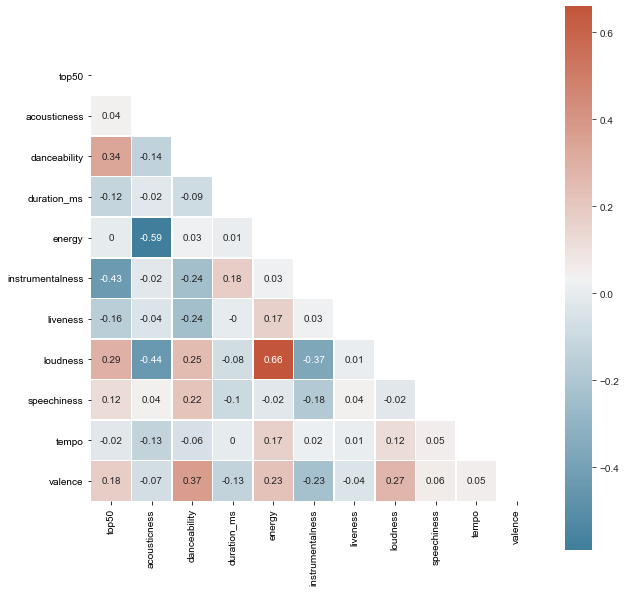

In [26]:
#
corr = round(analysis_stan.corr(),2)
f, ax = plt.subplots(figsize=(10, 10))
sns.set_style("darkgrid")
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True,annot=True)
plt.savefig('correlation_matrix.png')

plt.show()

#### Create dummies of categorical features

In [27]:
from sklearn.preprocessing import OneHotEncoder
#picking only the categroical vairbles : key and mode
cat = analysis_stan[categorical_feat]
enc = OneHotEncoder()
cat_encoded = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())

#### Setting up X and y

In [28]:
X = pd.concat((analysis_stan[continuous_feat], cat_encoded), axis=1)
y=analysis_stan['top50']
X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,x0_key_0,x0_key_1,x0_key_10,x0_key_11,x0_key_2,x0_key_3,x0_key_4,x0_key_5,x0_key_6,x0_key_7,x0_key_8,x0_key_9,x1_Major,x1_Minor
0,-0.419544,0.948384,-0.262276,-0.511815,-0.440440,-0.313029,1.190899,-0.137421,1.773060,1.138295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.006854,-0.287823,-0.021678,0.978496,-0.440457,0.255144,1.230944,-0.553795,1.987929,1.368676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.006854,1.066414,-0.135267,-0.158443,-0.440056,-0.836520,1.282833,-0.336126,1.768401,0.765497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.856220,-0.281611,0.783844,0.855584,-0.440457,-0.539195,0.921019,2.121713,-0.969119,0.794818,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.812819,0.637780,-0.086555,-0.230141,-0.440457,-0.784667,0.619273,0.497445,2.560513,1.046143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [29]:
y.value_counts()

1    9079
0    8679
Name: top50, dtype: int64

#### Split test and train


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

#### Evaluation function
returning model, score, precision, recall, f1 score

In [31]:
def get_scores(model,X_test,y_test,prediction):
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    eval_model={
            'Model': model,
            'Score': model.score(X_test, y_test),
            'Precision': precision_score(y_test, prediction, pos_label=1),#knear_pred predicitons of k nearest neighbour
            'Recall': recall_score(y_test, prediction, pos_label=1),
            'F1-Score': f1_score(y_test, prediction, pos_label=1)}
    return pd.DataFrame(eval_model,index=[0])

# K NEAREST NEIGHBOUR
* distance based algorithms demand that all variables need to be standardized
* they all need to be on the same scale 

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

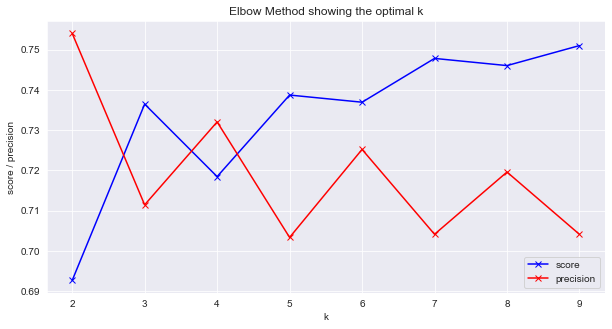

In [32]:
# elbow plot to check k

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

K = range(2, 10)
score_checker=[]
precision_checker=[]
for k in K:
    knear_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    score_checker.append(knear_model.score(X_test, y_test))
    knear_pred = knear_model.predict(X_test)
    precision_checker.append(precision_score(y_test, knear_pred, pos_label=1))
plt.figure(figsize=(10,5))
ax1=plt.plot(K, score_checker, 'bx-',color='blue', label='score')
ax2=plt.plot(K, precision_checker, 'bx-',color='red',label='precision')
plt.legend()
plt.xlabel('k')
plt.ylabel('score / precision')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [33]:
knear_model = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
knear_pred = knear_model.predict(X_test)


### Evaluate k nearest neighbour w/ score

In [34]:
print(pd.Series(knear_pred).value_counts())

0    5464
1    5191
dtype: int64


### Evaluate k nearest neighbours w/ scroe, precision, recall and f1

In [35]:
eval_knear_df=get_scores(knear_model,X_test,y_test,knear_pred)
eval_knear_df

,Model,Score,Precision,Recall,F1-Score
0,KNeighborsClassifier(n_neighbors=4),0.718442,0.732036,0.702533,0.716981


### Evaluate k nearest neighbours w/ Confusion Matrix and heatmap

In [36]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, knear_pred)#knear_pred predicitons of k nearest neighbour
print(cf_matrix)


[[3855 1391]
 [1609 3800]]


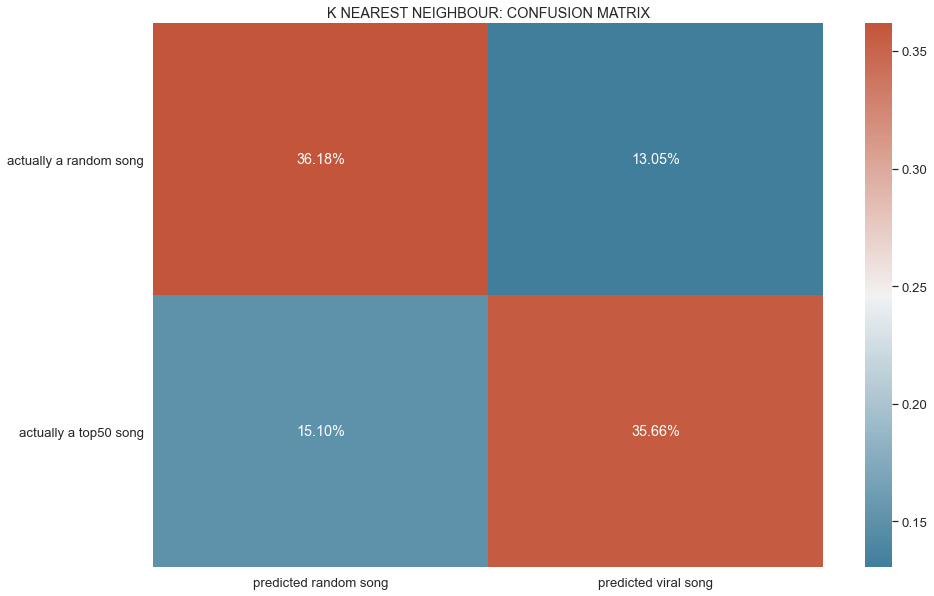

In [37]:
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap
sns.set(font_scale=1.2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted viral song'],
            yticklabels=['actually a random song','actually a top50 song']).set_title('K NEAREST NEIGHBOUR: CONFUSION MATRIX')
plt.yticks(rotation = 0)
plt.show()


# DECISION TREE

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)


### Evaluate decision tree

In [39]:
eval_dt_df=get_scores(dt_model,X_test,y_test,dt_pred)
eval_dt_df

,Model,Score,Precision,Recall,F1-Score
0,DecisionTreeClassifier(),0.7145,0.721671,0.712331,0.716971


confusion matrix: 
 [[3760 1486]
 [1556 3853]]


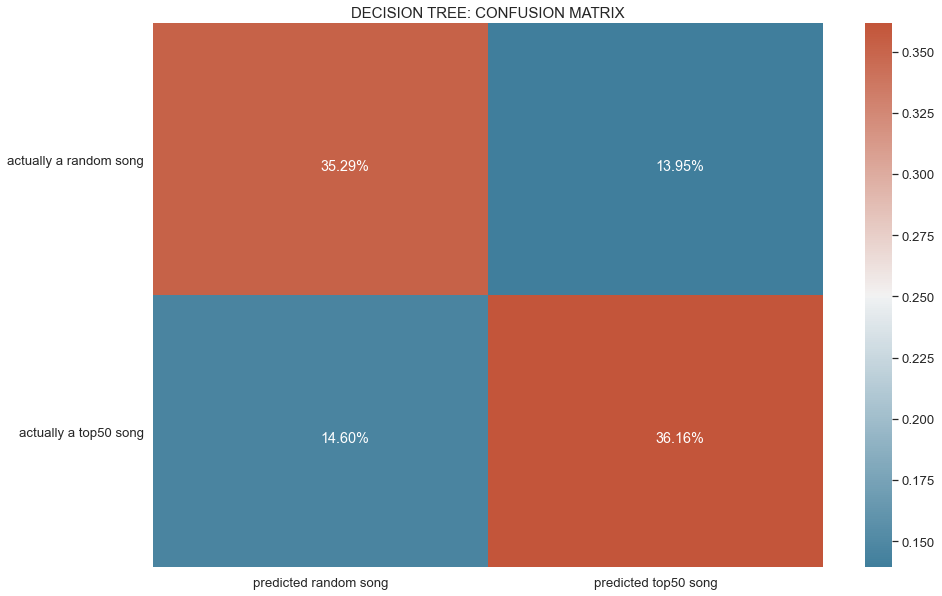

In [40]:
cf_matrix = confusion_matrix(y_test, dt_pred) #dt_pred : predictions decision tree
print('confusion matrix: \n',cf_matrix)
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

akws = {'ha': 'left','va': 'top'}

ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws=akws,
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted top50 song'],
            yticklabels=['actually a random song','actually a top50 song'])
plt.yticks(rotation = 0)
plt.title('DECISION TREE: CONFUSION MATRIX', size=15)
plt.show()

### Feature importance
in decision tree

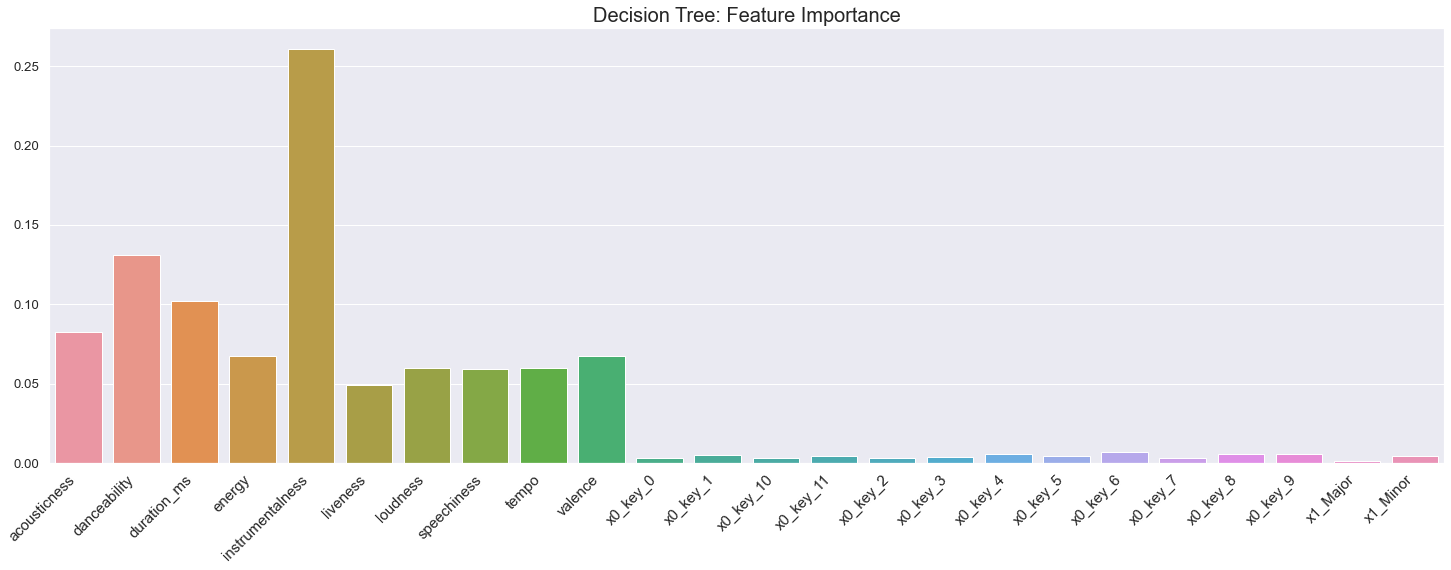

In [41]:
# feature importance embedded in y axis
f, ax = plt.subplots(figsize=(25, 8))
ax = sns.barplot(x=X.columns, 
                 y=dt_model.feature_importances_).set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right', size = 15)
plt.title('Decision Tree: Feature Importance', size=20)
plt.show()


In [42]:
pd.DataFrame(dict(zip(X.columns, dt_model.feature_importances_)),index=[0]).T.rename(columns={0:'importance'}).sort_values(by='importance',ascending=False).head().style.bar(color='lightblue',vmin=0.0, vmax=1.0)

,importance
instrumentalness,0.260887
danceability,0.130833
duration_ms,0.102240
acousticness,0.082659
valence,0.067624


# RANDOM FOREST

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier().fit(X_train, y_train)
forest_pred = forest_model.predict(X_test)

### Evaluate Random Forest

In [44]:
"""
#function aint working for random forest?

eval_forest_df=get_scores(forest_model,X_test,y_test,forest_pred)
eval_forest_df"""

'\n#function aint working for random forest?\n\neval_forest_df=get_scores(forest_model,X_test,y_test,forest_pred)\neval_forest_df'

In [45]:
forest_model.score(X_test, y_test)

0.8020647583294228

In [46]:
#evaluate decision tree : eval_forest
from sklearn.metrics import precision_score, recall_score, f1_score
eval_forest={
    
            'Model': 'Random Forest',
            'Score': forest_model.score(X_test, y_test),
            'Precision': precision_score(y_test, forest_pred, pos_label=1),
            'Recall': recall_score(y_test, forest_pred, pos_label=1),
            'F1-Score': f1_score(y_test, forest_pred, pos_label=1)}

eval_forest_df=pd.DataFrame(eval_forest,index=[0])
eval_forest_df

,Model,Score,Precision,Recall,F1-Score
0,Random Forest,0.802065,0.773723,0.862267,0.815598


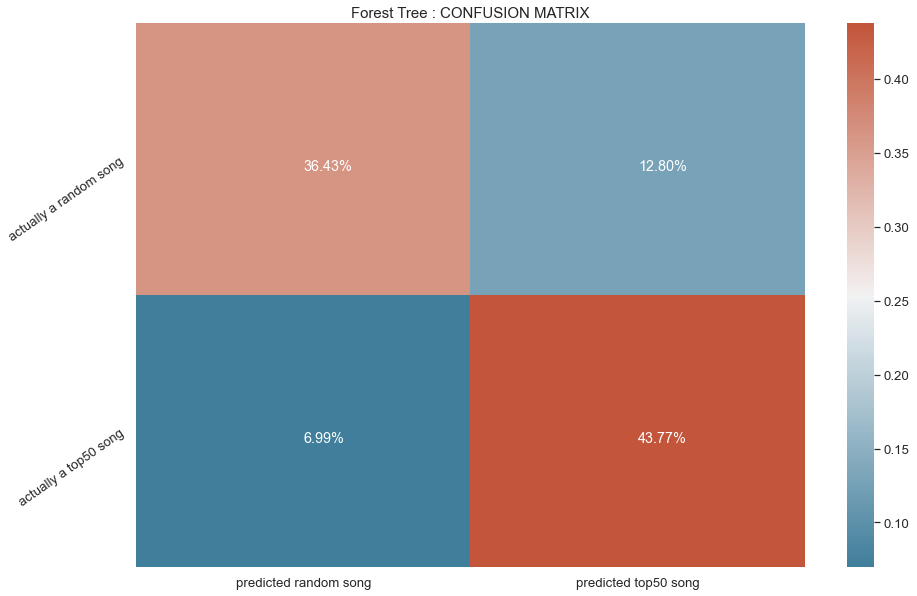

In [47]:
cf_matrix = confusion_matrix(y_test, forest_pred) #dforest_pred : predictions forest tree
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

akws = {'ha': 'left','va': 'top'}

ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws=akws,
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted top50 song'],
            yticklabels=['actually a random song','actually a top50 song'])
plt.yticks(rotation = 35)
plt.title('Forest Tree : CONFUSION MATRIX', size=15)
plt.savefig('Confusion Matrix Random Forest.png')
plt.show()

### Feature importance
in random forest

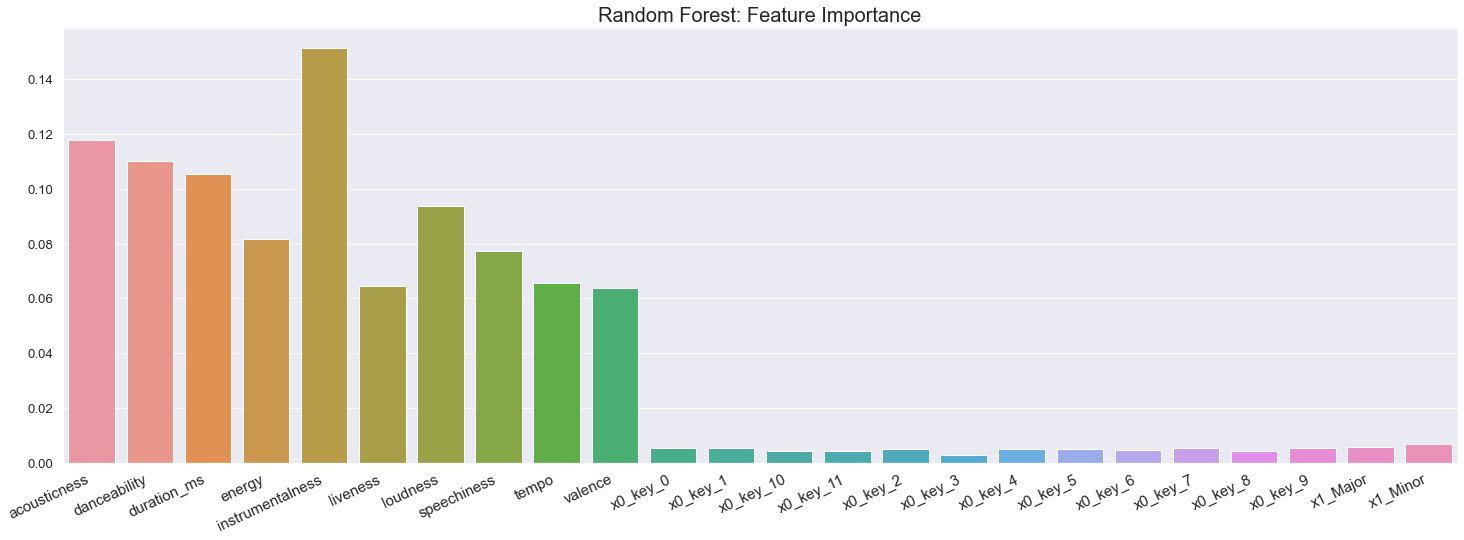

In [48]:
# feature importance embedded in y axis
f, ax = plt.subplots(figsize=(25, 8))
ax = sns.barplot(x=X.columns, 
                 y=forest_model.feature_importances_).set_xticklabels(ax.get_xticklabels(), 
                          rotation=25, 
                          horizontalalignment='right', size = 15)
plt.title('Random Forest: Feature Importance', size=20)
plt.savefig('feature_importance.png')
plt.show()


# SVM SUPPORT VECTOR MACHINE

In [49]:
from sklearn.svm import SVC

In [50]:
svm_model = SVC(probability=True).fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)


### Evaluate Support Verctor Classifier

In [51]:
print(pd.Series(svm_pred).value_counts())
###
eval_svm_df=get_scores(svm_model,X_test,y_test,svm_pred)
eval_svm_df

1    6616
0    4039
dtype: int64


,Model,Score,Precision,Recall,F1-Score
0,SVC(probability=True),0.781417,0.732769,0.896284,0.80632


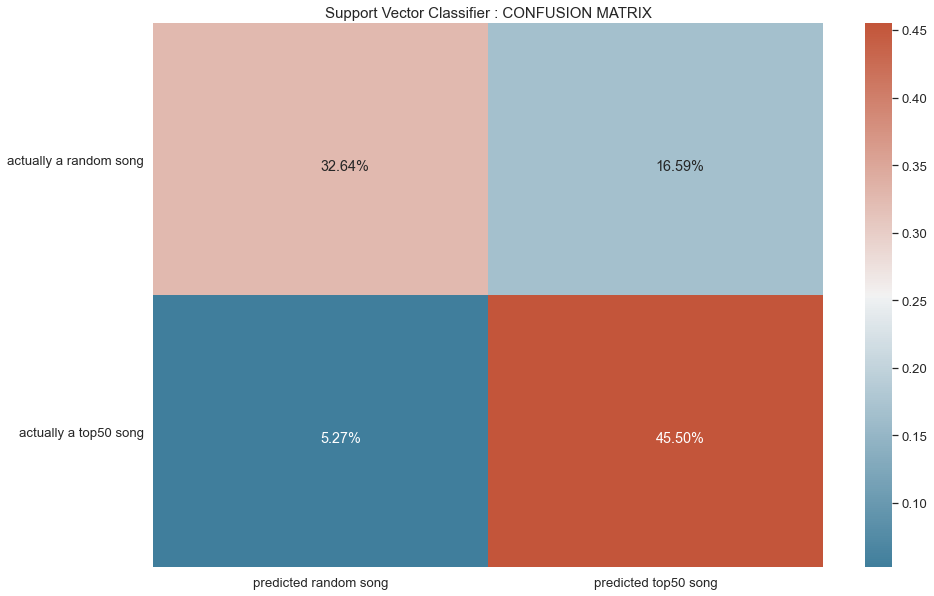

In [52]:
cf_matrix = confusion_matrix(y_test, svm_pred) #dforest_pred : predictions forest tree
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

akws = {'ha': 'left','va': 'top'}

ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws=akws,
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted top50 song'],
            yticklabels=['actually a random song','actually a top50 song'])
plt.yticks(rotation = 0)
plt.title('Support Vector Classifier : CONFUSION MATRIX', size=15)
#plt.savefig('SVC Confusion Matrix.png')
plt.show()

### Feature importance
in decision tree

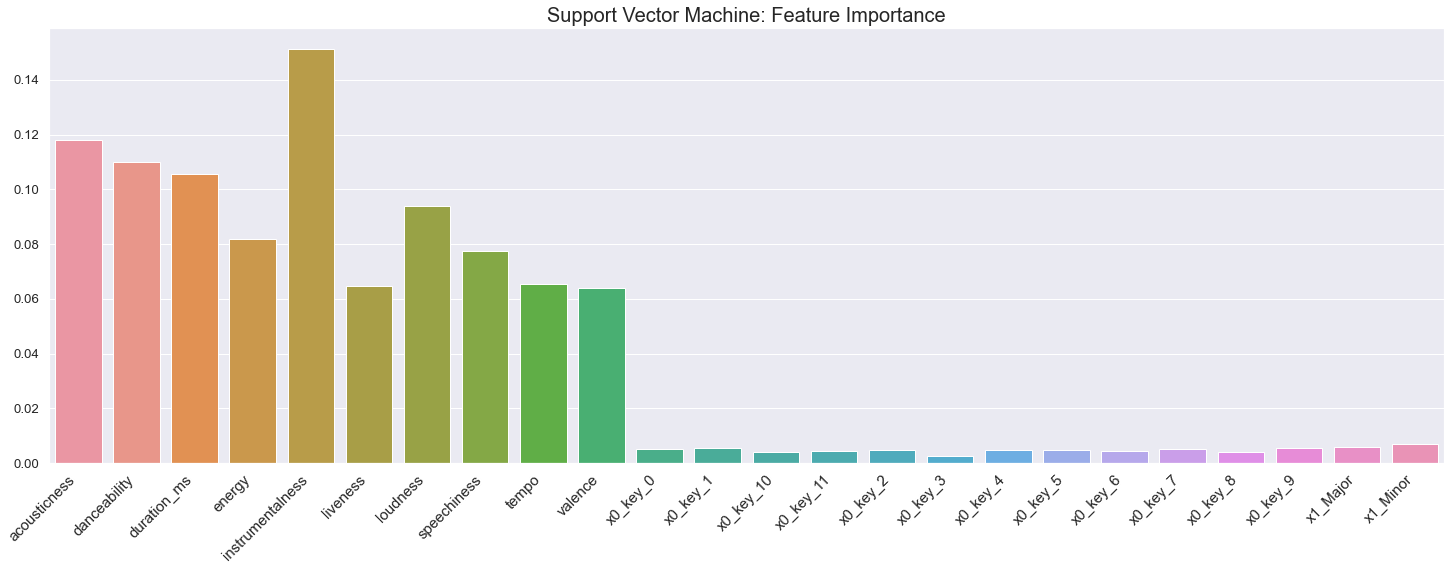

In [53]:
# feature importance embedded in y axis
f, ax = plt.subplots(figsize=(25, 8))
ax = sns.barplot(x=X.columns, 
                 y=forest_model.feature_importances_).set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right', size = 15)
plt.title('Support Vector Machine: Feature Importance', size=20)
plt.show()

# EVALUATION SUM UP

In [54]:
# eval_sumup=pd.concat([eval_knear_df,eval_dt_df,eval_forest_df,eval_svm_df],axis=0,ignore_index=True).style.bar(color='lightblue', vmin=0.0, vmax=1.0).set_caption('MODEL SCORE COMPARIOSN')
eval_sumup=pd.concat([eval_knear_df,eval_dt_df,eval_forest_df,eval_svm_df],axis=0,ignore_index=True).style.highlight_max(color='lightblue').set_caption('MODEL SCORE COMPARIOSN')
eval_sumup

,Model,Score,Precision,Recall,F1-Score
0,KNeighborsClassifier(n_neighbors=4),0.718442,0.732036,0.702533,0.716981
1,DecisionTreeClassifier(),0.714500,0.721671,0.712331,0.716971
2,Random Forest,0.802065,0.773723,0.862267,0.815598
3,SVC(probability=True),0.781417,0.732769,0.896284,0.806320


#  RADAR PLOT
### FEATURE MEANS OF VIRAL SONGS VERSUS DER FEATURE MEANS OF KAGGLE SONGS
reference: https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way

In [55]:
labels=np.array(analysis_true[continuous_feat].columns)
top50_songs_stats=analysis_true[continuous_feat][analysis_true['top50']==1].mean().values

###
base_songs_stats=analysis_true[continuous_feat][analysis_true['top50']==0].mean().values


In [56]:
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
###
top50_songs_stats=np.concatenate((top50_songs_stats,[top50_songs_stats[0]]))
base_songs_stats=np.concatenate((base_songs_stats,[base_songs_stats[0]]))

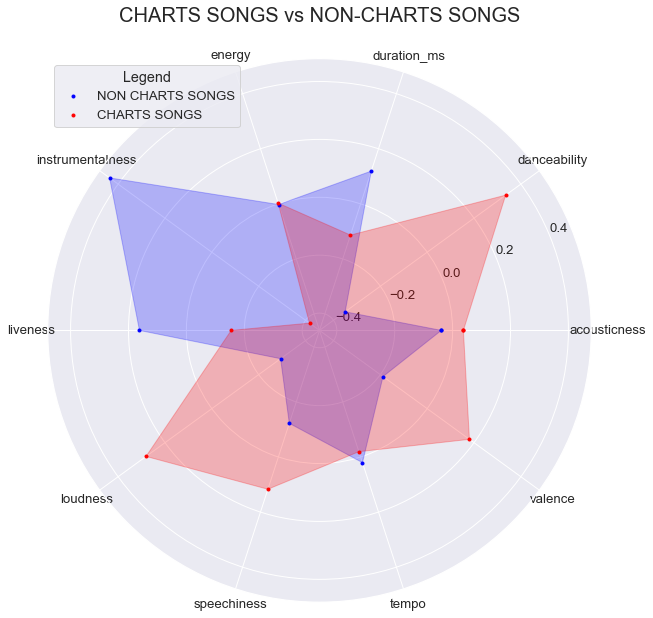

In [57]:
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
plot1=ax.plot(angles, base_songs_stats, '.', linewidth=2, label='NON CHARTS SONGS',color='blue')
plot2=ax.plot(angles, top50_songs_stats, '.', linewidth=2, label='CHARTS SONGS',color='red')
ax.fill(angles, base_songs_stats, alpha=0.25, color='blue')
ax.fill(angles, top50_songs_stats, alpha=0.25, color='red')
ax.set_thetagrids((angles * 180/np.pi)[0:10], labels)
plt.legend(title='Legend', loc='upper left')
ax.set_title('CHARTS SONGS vs NON-CHARTS SONGS\n',size=20)
ax.grid(True)
#plt.savefig('radaplot.png')
plt.show()


In [58]:
#################################################

# RUN PREDICTOR: 

In [59]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.oauth2 as oauth2
import os
import re

## Single Track Predictor
Function that will apply the model on all songs of a spotify album

In [60]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

In [61]:

def predict_hit(url,continuous_feat,categorical_feat):
    
    ###
    
    my_client_id=os.getenv('spoti_CLIENT_ID')
    my_client_secret=os.getenv('spoti_CLIENT_SECRET')
    sp=spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret))

    ###
    
    meta_feat=['ID','Track_Name','Artist','Audio']
    
    #set up to call spotify API
    song_id=re.findall(r'\d\w+',str(url))[0]
    
    meta = sp.track(song_id)
    features = sp.audio_features(song_id)
    analysis= sp.audio_analysis(song_id)
    
    #create dictionary
    keys=[i for i in meta_feat+continuous_feat+categorical_feat] #these lists should contain the nemes of all features I need
    values=[song_id,
            meta['name'],#song title
            meta['artists'][0]['name'],#artist name
            meta['preview_url'], #audio sinppet 30secs
            features[0]['acousticness'],
            features[0]['danceability'],
            meta['duration_ms'],
            features[0]['energy'],
            features[0]['instrumentalness'],
            features[0]['liveness'],
            features[0]['loudness'],
            features[0]['speechiness'],
            features[0]['tempo'],
            features[0]['valence'],
            features[0]['key'],
            features[0]['mode']]

    df=pd.DataFrame(dict(zip(keys,values)),index=[0])
    
    #standardize the contnuous feature only: using the scaler i fitted with all continuouse variables
    df[continuous_feat]=pd.DataFrame(scaler.transform(df[continuous_feat]),columns=continuous_feat)
    
    #recreate dummies for keys
    for i in range(0,12):
        if df['key'][0] == i:
            df[f'x0_key_{i}']=1.0
        else:
            df[f'x0_key_{i}']=0.0
    df.drop('key',axis=1,inplace=True)
    
    #recreate dummies for keys
    df['x1_Major']=np.where(df['mode'] == 1,1.0,0.0)
    df['x1_Minor']=np.where(df['mode'] == 0,1.0,0.0)
    df.drop('mode',axis=1, inplace=True)

    X_NEW=df.drop(['ID','Track_Name','Artist','Audio'],axis=1)
    
    #MAKING PREDICTION
    dt_result=dt_model.predict(X_NEW)
    knear_result=round(knear_model.predict_proba(X_NEW)[0][1],2)
    forest_probability=round(forest_model.predict_proba(X_NEW)[0][1],2) #probablitiy positiv
    svm_probability=round(svm_model.predict_proba(X_NEW)[0][1],2)
    
    #RADAR PLOT OF GIVEN SONGS
    
    labels=np.array(continuous_feat)
    stats=df.loc[0,labels].values
    
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=1, color='white')
    ax.fill(angles, stats, alpha=0.25,color='red')
    ax.set_thetagrids((angles * 180/np.pi)[0:10], labels)
    ax.set_title(f"{meta['artists'][0]['name']} - {meta['name']}")
    ax.grid(True)
    
    
    #RETURN
    results_dic={'Artist':df['Artist'][0],
                 'Song':df['Track_Name'][0],
                 #'DecisionTree': np.where(dt_result==1,'approved','failed'),
                 #'K-Near':f'{round(knear_result*100,2)}%',
                 #'Audio':df['Audio'][0],                              
                 'RandForest':f'{round(forest_probability*100,2)}%',
                 'SVM-Model':f'{round(svm_probability*100,2)}%',

                 #'Actual Popularity': meta['popularity']
                }
       
    print('\n------')
    return pd.DataFrame(results_dic,index=[0])





Paste URL of Spotify Song
Should look like this: https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN
https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN

------


,Artist,Song,RandForest,SVM-Model
0,Automatic,Too Much Money,19.0%,30.0%


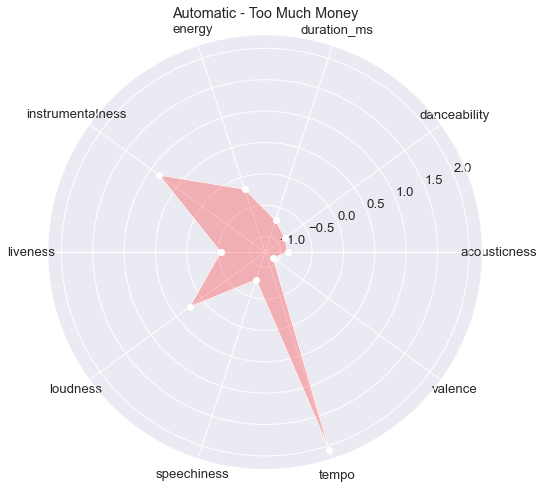

In [62]:
#keep ththis works
print('Paste URL of Spotify Song\nShould look like this: https://open.spotify.com/track/7qzftATxwdp8G78aMmizXN')
url=input().strip(' ')
predict_hit(url,continuous_feat,categorical_feat)

In [63]:
########################################

# PASS ALBUM ID
Function that will apply the model on all songs of a spotify album

In [64]:
def predict_hit_album(url_album, continuous_feat,categorical_feat):
    
    # authentification
    my_client_id=os.getenv('spoti_CLIENT_ID')
    my_client_secret=os.getenv('spoti_CLIENT_SECRET')
    sp=spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret))
    
    #extract album id
    album_id=re.findall(r'\d\w+',str(url_album))[0]

    #extract ids of each album track
    url_list=[sp.album_tracks(album_id)['items'][i]['id'] for i in range(len(sp.album_tracks(album_id)['items']))]  

    ###
    meta_feat=['ID','Track_Name','Artist','Audio']
    ###
    
    #loop through ids
    list_results=[] # here I ll collect the dictionaries as a list to create a single dataframe 
    for i in url_list:
        

        #set up to call spotify API
        song_id=re.findall(r'\d\w+',str(i))[0]

        meta = sp.track(song_id)
        features = sp.audio_features(song_id)
        analysis= sp.audio_analysis(song_id)

        #create dictionary
        keys=[i for i in meta_feat+continuous_feat+categorical_feat] #these lists should contain the nemes of all features I need
        values=[song_id,
                meta['name'],#song title
                meta['artists'][0]['name'],#artist name
                meta['preview_url'], #audio sinppet 30secs
                features[0]['acousticness'],
                features[0]['danceability'],
                meta['duration_ms'],
                features[0]['energy'],
                features[0]['instrumentalness'],
                features[0]['liveness'],
                features[0]['loudness'],
                features[0]['speechiness'],
                features[0]['tempo'],
                features[0]['valence'],
                features[0]['key'],
                features[0]['mode']]

        df=pd.DataFrame(dict(zip(keys,values)),index=[0])

        #standardize the contnuous feature only: using the scaler i fitted with all continuouse variables
        df[continuous_feat]=pd.DataFrame(scaler.transform(df[continuous_feat]),columns=continuous_feat)

        #recreate dummies for keys
        for i in range(0,12):
            if df['key'][0] == i:
                df[f'x0_key_{i}']=1.0
            else:
                df[f'x0_key_{i}']=0.0
        df.drop('key',axis=1,inplace=True)

        #recreate dummies for keys
        df['x1_Major']=np.where(df['mode'] == 1,1.0,0.0)
        df['x1_Minor']=np.where(df['mode'] == 0,1.0,0.0)
        df.drop('mode',axis=1, inplace=True)
        
        #MAKING PREDICTION
        X_NEW=df.drop(['ID','Track_Name','Artist','Audio'],axis=1)
        dt_result=dt_model.predict(X_NEW)
        knear_result=round(knear_model.predict_proba(X_NEW)[0][1],2)
        forest_probability=round(forest_model.predict_proba(X_NEW)[0][1],2) #probablitiy positiv
        svm_probability=round(svm_model.predict_proba(X_NEW)[0][1],2)

        #dictionary
        results_dic={'Artist':df['Artist'][0],
                     'Song':df['Track_Name'][0],
                     #'DecisionTree': np.where(dt_result==1,'approved','failed'),
                     #'K-Near':f'{round(knear_result*100,2)}%',
                     'RandForest':f'{round(forest_probability*100,2)}%',
                     'SVM-Model':f'{round(svm_probability*100,2)}%',
                     'Recommender':round(round(forest_probability*100,0)+round(svm_probability*100,0),0),#addiere forest und SVM                     
                     'Audio':df['Audio'][0],
                     'Actual Popularity': meta['popularity']
                    }
        list_results.append(results_dic)
        
         #RADAR PLOT OF GIVEN SONGS
        labels=np.array(continuous_feat)
        stats=df.loc[0,labels].values

        angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)# close the plot
        stats=np.concatenate((stats,[stats[0]]))
        angles=np.concatenate((angles,[angles[0]]))

        fig=plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, stats, 'o-', linewidth=1, color='white')
        ax.fill(angles, stats, alpha=0.25,color='red')
        ax.set_thetagrids((angles * 180/np.pi)[0:10], labels)
        ax.set_title(f"{meta['artists'][0]['name']} - {meta['name']}")
        ax.grid(True)
        
    print('\n------')
    return pd.DataFrame(list_results).sort_values(by='Recommender',ascending=False)

Paste URL of Spotify Album
Should look like this: https://open.spotify.com/album/6NtEjhPWfZcvJQuvjGX4bk
https://open.spotify.com/album/5zi7WsKlIiUXv09tbGLKsE?si=taFuunbcTe-XaNjmUVZ7Eg

------


,Artist,Song,RandForest,SVM-Model,Recommender,Audio,Actual Popularity
6,"Tyler, The Creator",A BOY IS A GUN*,76.0%,61.0%,137.0,https://p.scdn.co/mp3-preview/46094bdb549ff10e...,68
5,"Tyler, The Creator",NEW MAGIC WAND,74.0%,53.0%,127.0,https://p.scdn.co/mp3-preview/58710a799e86472a...,68
2,"Tyler, The Creator",I THINK,42.0%,84.0%,126.0,https://p.scdn.co/mp3-preview/02728662c29717a7...,71
9,"Tyler, The Creator","GONE, GONE / THANK YOU",46.0%,64.0%,110.0,https://p.scdn.co/mp3-preview/1aa624b1d03e219a...,75
10,"Tyler, The Creator",I DON'T LOVE YOU ANYMORE,46.0%,53.0%,99.0,https://p.scdn.co/mp3-preview/a7ffd5b770b27797...,62
8,"Tyler, The Creator",WHAT'S GOOD,52.0%,46.0%,98.0,https://p.scdn.co/mp3-preview/87940f109373e35e...,62
1,"Tyler, The Creator",EARFQUAKE,46.0%,14.0%,60.0,https://p.scdn.co/mp3-preview/d6528c193bac76f7...,80
0,"Tyler, The Creator",IGOR'S THEME,31.0%,22.0%,53.0,https://p.scdn.co/mp3-preview/1de2c6a55e578f83...,64
11,"Tyler, The Creator",ARE WE STILL FRIENDS?,25.0%,23.0%,48.0,https://p.scdn.co/mp3-preview/6b9c28b662670fa2...,66
7,"Tyler, The Creator",PUPPET,22.0%,17.0%,39.0,https://p.scdn.co/mp3-preview/492d84a17ec8fa6f...,64


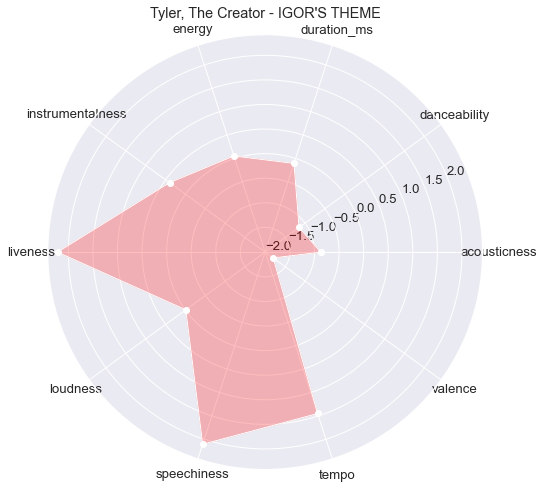

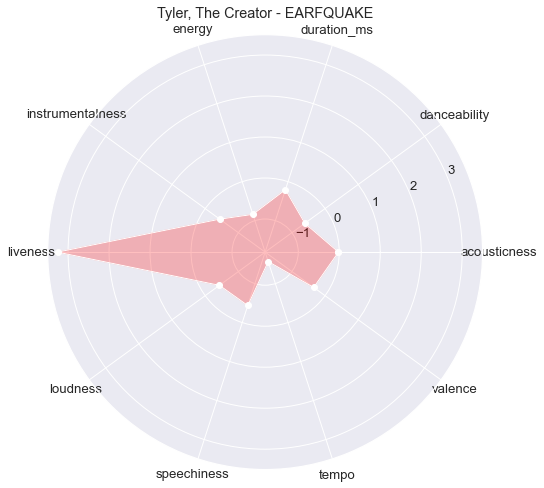

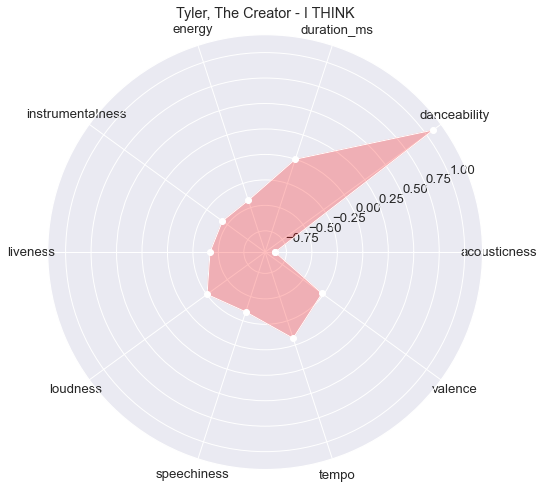

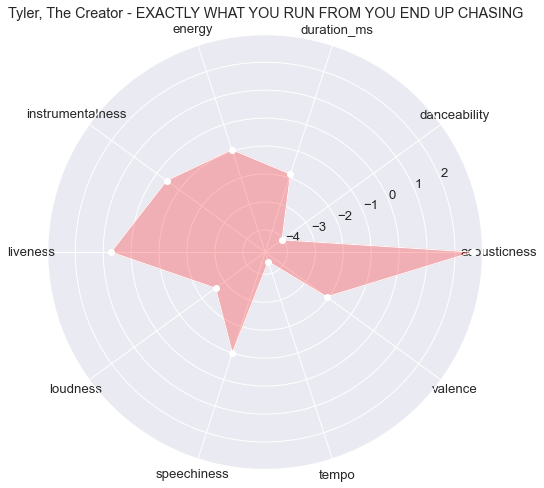

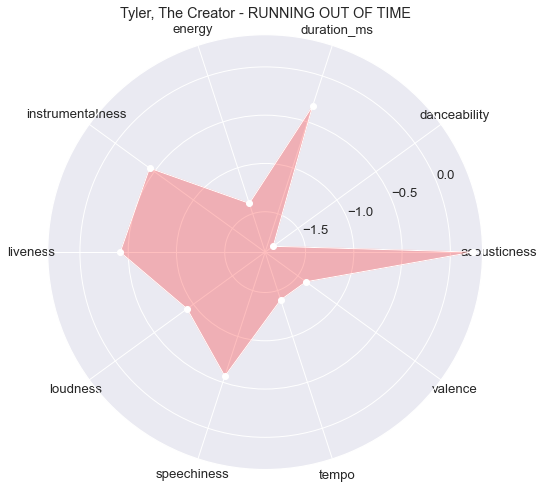

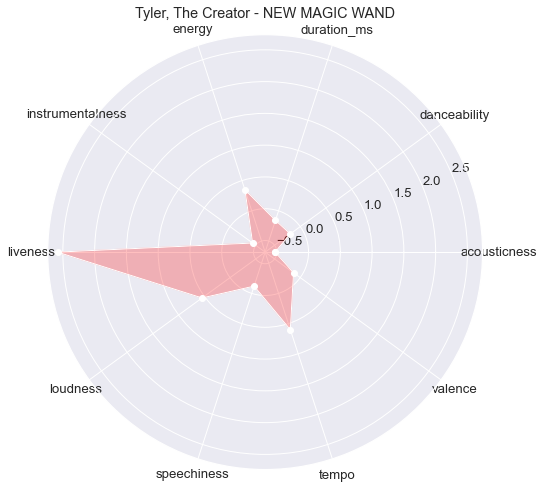

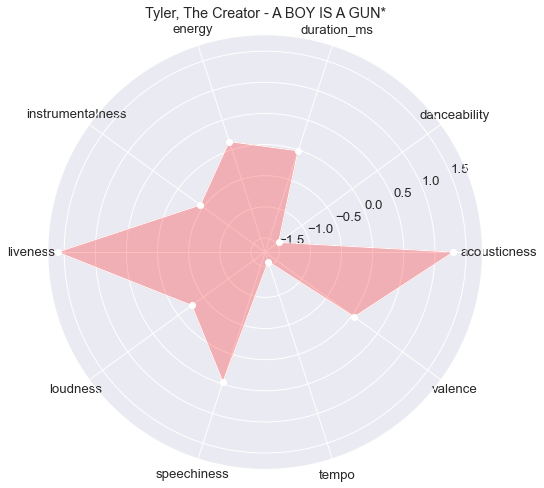

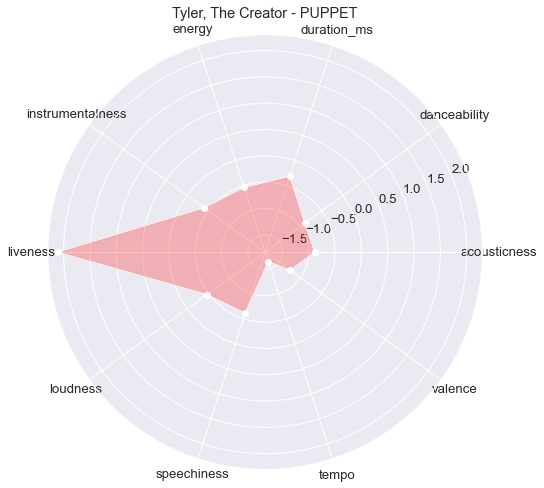

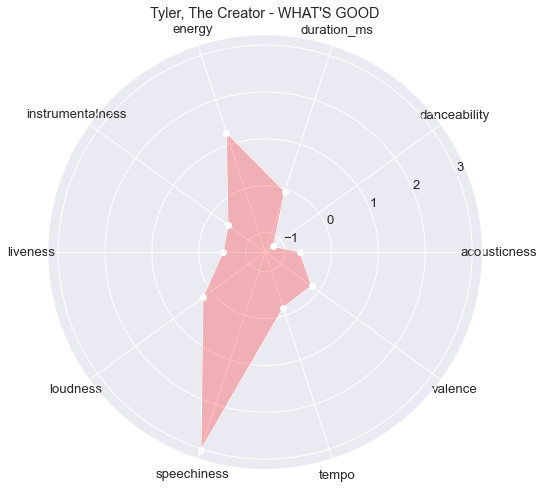

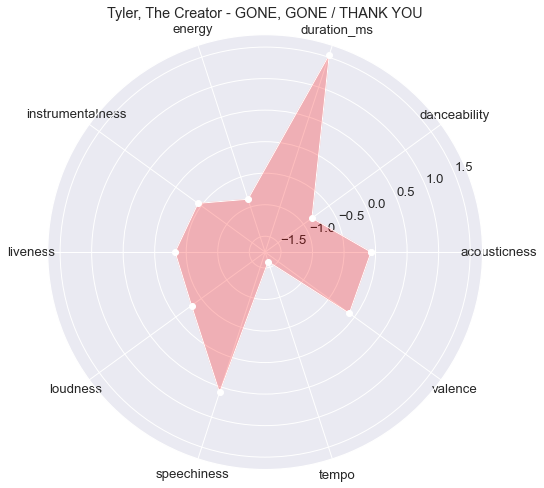

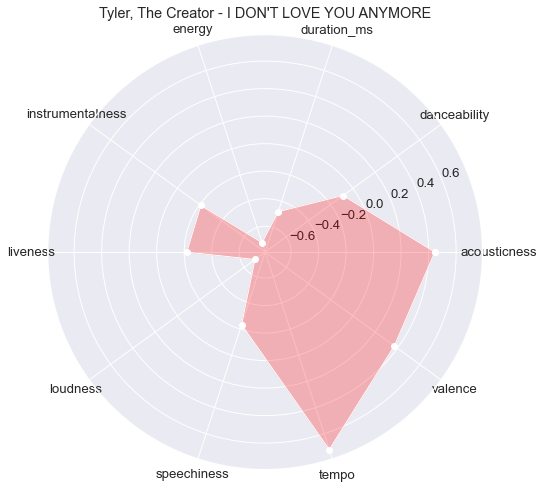

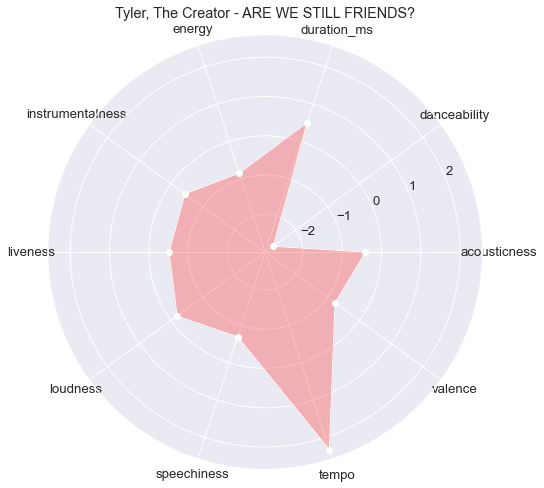

In [65]:
print('Paste URL of Spotify Album\nShould look like this: https://open.spotify.com/album/6NtEjhPWfZcvJQuvjGX4bk')
url_album=input().strip(' ')
predict_hit_album(url_album, continuous_feat,categorical_feat)

-


# PASS LIST OF IDs
Function that will apply the model on list of spotify track URLs

In [66]:
def predict_hit_list(url_list, continuous_feat,categorical_feat):

    my_client_id=os.getenv('spoti_CLIENT_ID')
    my_client_secret=os.getenv('spoti_CLIENT_SECRET')
    sp=spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=my_client_id, client_secret=my_client_secret))
    
    ###
    meta_feat=['ID','Track_Name','Artist','Audio']
    ###
    
    #loop through ids
    list_results=[] # here I ll collect the dictionaries as a list to create a single dataframe 
    for i in url_list:
        

        #set up to call spotify API
        song_id=re.findall(r'\d\w+',str(i))[0]

        meta = sp.track(song_id)
        features = sp.audio_features(song_id)
        analysis= sp.audio_analysis(song_id)

        #create dictionary
        keys=[i for i in meta_feat+continuous_feat+categorical_feat] #these lists should contain the nemes of all features I need
        values=[song_id,
                meta['name'],#song title
                meta['artists'][0]['name'],#artist name
                meta['preview_url'], #audio sinppet 30secs
                features[0]['acousticness'],
                features[0]['danceability'],
                meta['duration_ms'],
                features[0]['energy'],
                features[0]['instrumentalness'],
                features[0]['liveness'],
                features[0]['loudness'],
                features[0]['speechiness'],
                features[0]['tempo'],
                features[0]['valence'],
                features[0]['key'],
                features[0]['mode']]

        df=pd.DataFrame(dict(zip(keys,values)),index=[0])

        #standardize the contnuous feature only: using the scaler i fitted with all continuouse variables
        df[continuous_feat]=pd.DataFrame(scaler.transform(df[continuous_feat]),columns=continuous_feat)

        #recreate dummies for keys
        for i in range(0,12):
            if df['key'][0] == i:
                df[f'x0_key_{i}']=1.0
            else:
                df[f'x0_key_{i}']=0.0
        df.drop('key',axis=1,inplace=True)

        #recreate dummies for keys
        df['x1_Major']=np.where(df['mode'] == 1,1.0,0.0)
        df['x1_Minor']=np.where(df['mode'] == 0,1.0,0.0)
        df.drop('mode',axis=1, inplace=True)
        
        #MAKING PREDICTION
        X_NEW=df.drop(['ID','Track_Name','Artist','Audio'],axis=1)
        dt_result=dt_model.predict(X_NEW)
        knear_result=round(knear_model.predict_proba(X_NEW)[0][1],2)
        forest_probability=round(forest_model.predict_proba(X_NEW)[0][1],2) #probablitiy positiv
        svm_probability=round(svm_model.predict_proba(X_NEW)[0][1],2)

        #dictionary
        results_dic={'Artist':df['Artist'][0],
                     'Song':df['Track_Name'][0],
                     #'DecisionTree': np.where(dt_result==1,'approved','failed'),
                     #'K-Near':f'{round(knear_result*100,2)}%',
                     'RandForest':f'{round(forest_probability*100,2)}%',
                     'SVM-Model':f'{round(svm_probability*100,2)}%',
                    'Recommender':round(round(forest_probability*100,0)+round(svm_probability*100,0),0),#addiere forest und SVM
                     'Audio':df['Audio'][0],
                     #'Actual Popularity': meta['popularity']
                    }
        list_results.append(results_dic)
        
         #RADAR PLOT OF GIVEN SONGS
        labels=np.array(continuous_feat)
        stats=df.loc[0,labels].values

        angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)# close the plot
        stats=np.concatenate((stats,[stats[0]]))
        angles=np.concatenate((angles,[angles[0]]))

        fig=plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, stats, 'o-', linewidth=1, color='white')
        ax.fill(angles, stats, alpha=0.25,color='red')
        ax.set_thetagrids((angles * 180/np.pi)[0:10], labels)
        ax.set_title(f"{meta['artists'][0]['name']} - {meta['name']}")
        ax.grid(True)
        
    print('\n------')
    return pd.DataFrame(list_results).sort_values(by='Recommender',ascending=False)

In [67]:
#customize a list of Spotify URLs
url_list=['https://open.spotify.com/track/5QO79kh1waicV47BqGRL3g?si=622033daeda64bb9',
         'https://open.spotify.com/track/1diS6nkxMQc3wwC4G1j0bh?si=e87831b8ef4b40bf',
         'https://open.spotify.com/track/2qTy3hGSbxoSenKmlKGHFw?si=6c309c76ced44a9d',
         'https://open.spotify.com/track/6imeB9iHkhAj0Q5sAAANB3?si=84bede912d174004',
         'https://open.spotify.com/track/5CqkgDH8QZjSqqI3HmYxDD?si=5824a5ff446a4e8c',
         'https://open.spotify.com/track/67ojvEGRPAUCOohuMPqoRC?si=30d3514255034c55',
         'https://open.spotify.com/track/2JO3HwMRPeya8bXbtbyPcf?si=ea645a03971849fc']


------


,Artist,Song,RandForest,SVM-Model,Recommender,Audio
5,Capital Bra,110,96.0%,78.0%,174.0,None
3,Perfume Genius,Without You - Jim-E Stack Remix,82.0%,83.0%,165.0,https://p.scdn.co/mp3-preview/81d8839373315e92...
4,Pashanim,Airwaves,64.0%,73.0%,137.0,None
1,Dua Lipa,We're Good,61.0%,68.0%,129.0,https://p.scdn.co/mp3-preview/013c740f4d39f201...
2,St. Vincent,Los Ageless,59.0%,68.0%,127.0,None
0,The Weeknd,Save Your Tears,65.0%,61.0%,126.0,None
6,Joy Division,Love Will Tear Us Apart,4.0%,1.0%,5.0,https://p.scdn.co/mp3-preview/18a4b498250ed137...


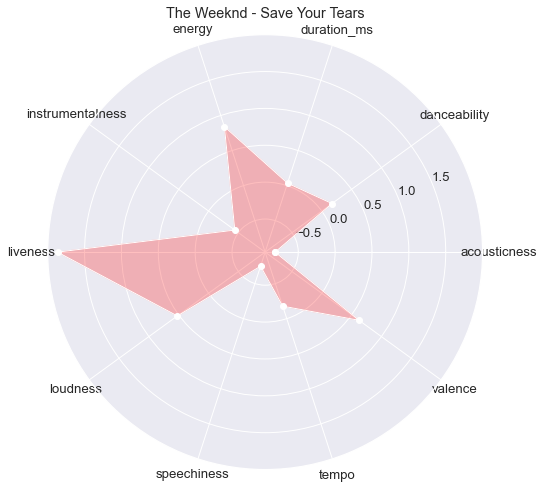

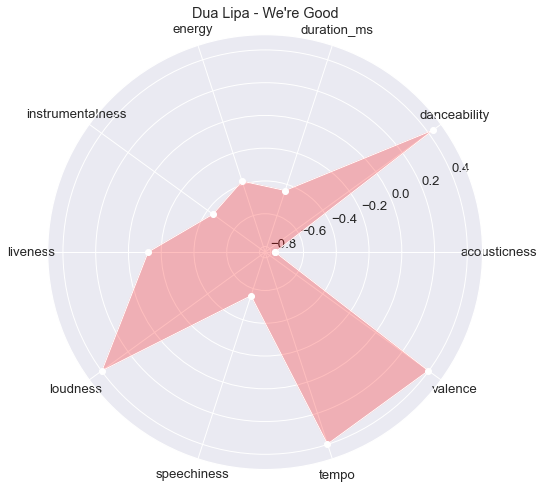

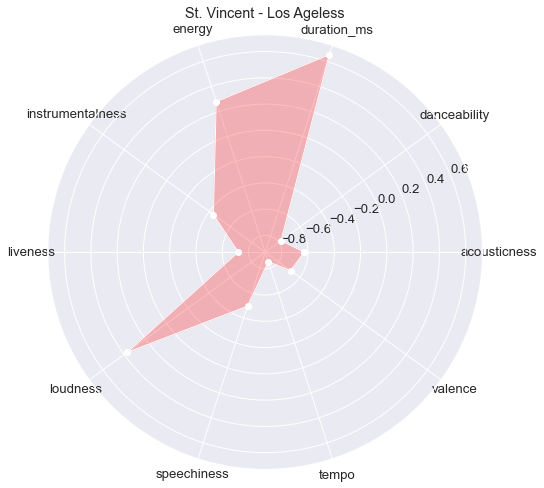

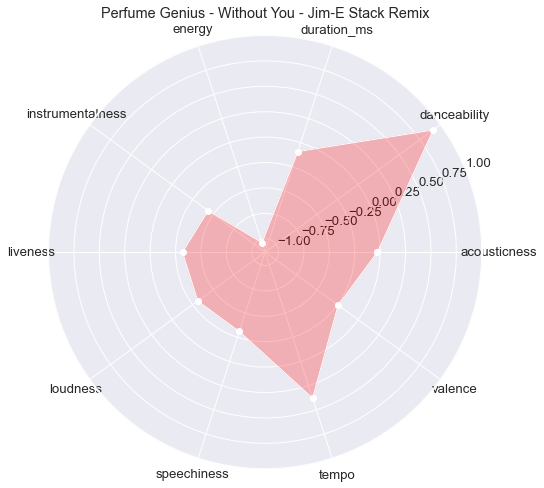

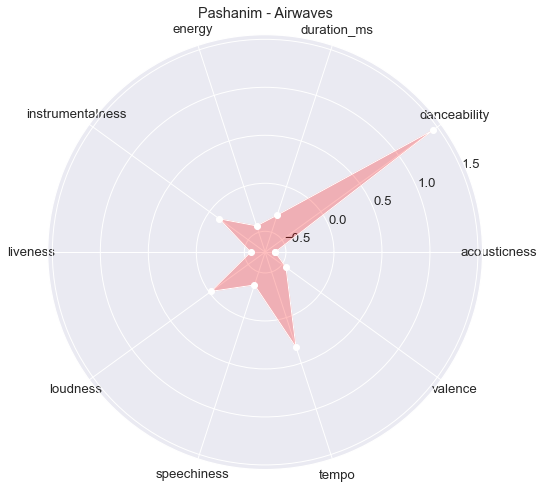

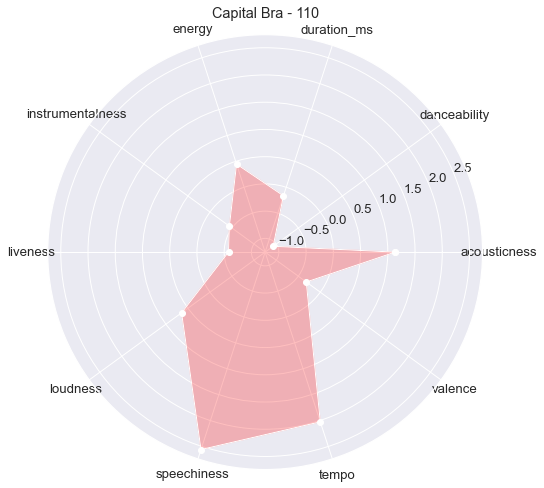

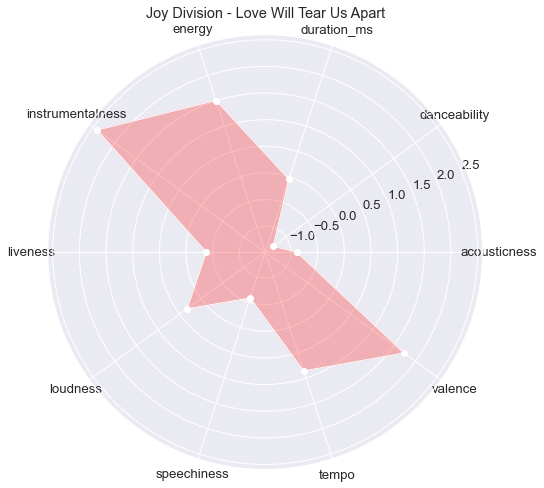

In [68]:
predict_hit_list(url_list, continuous_feat,categorical_feat)

# NOTES

PLOTS
https://seaborn.pydata.org/tutorial/distributions.html

In [69]:
"""    
    if result==1:
        return print(f"YEAH! THE COMMITTEE OF MEME CATS APPROVES!\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} will go viral\n------\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} meets {round(probability*100,2)}% of this model's viral qualities")
    else:
        return print(f"NOPE! The song „{(df['Track_Name'][0])}“ doesn't have what it takes - {df['Artist'][0].upper()} ain't on the meme-team\n------\n„{(df['Track_Name'][0])}“ by {df['Artist'][0].upper()} only meets this model's viral qualities by {round(probability*100,2)}%")
    
"""

'    \n    if result==1:\n        return print(f"YEAH! THE COMMITTEE OF MEME CATS APPROVES!\n„{(df[\'Track_Name\'][0])}“ by {df[\'Artist\'][0].upper()} will go viral\n------\n„{(df[\'Track_Name\'][0])}“ by {df[\'Artist\'][0].upper()} meets {round(probability*100,2)}% of this model\'s viral qualities")\n    else:\n        return print(f"NOPE! The song „{(df[\'Track_Name\'][0])}“ doesn\'t have what it takes - {df[\'Artist\'][0].upper()} ain\'t on the meme-team\n------\n„{(df[\'Track_Name\'][0])}“ by {df[\'Artist\'][0].upper()} only meets this model\'s viral qualities by {round(probability*100,2)}%")\n    \n'